In [1]:
# Option 1: If package is installed in editable mode (pip install -e .)
# You can directly import:
from skymap import utils

# Option 2: If package is not installed, add project root to path
# Uncomment the following lines if Option 1 doesn't work:
# import sys
# from pathlib import Path
# project_root = Path().resolve().parent  # Go up from notebooks/ to project root
# sys.path.insert(0, str(project_root))
# from scripts import utils

import numpy as np 
import matplotlib.pyplot as plt
import h5py

In [2]:
# Read the HDF5 file
from pathlib import Path

# Construct the file path relative to the notebook location
notebook_dir = Path().resolve()
data_file = notebook_dir.parent / "data_310" / "gbt_beam_scans_2026-01-13T150238.hdf5"

print(data_file)
# Read the data
data, keys = utils.read_hdf5_data(data_file)

print(f"File loaded: {data_file}")
print(f"\nTop-level keys in HDF5 file: {keys}")
print(f"\nAvailable datasets: {list(data.keys())}")

/Users/akshatha.vydula/packages_310/skymap/data_310/gbt_beam_scans_2026-01-13T150238.hdf5

Note: 2 dataset(s) could not be read and were skipped.
Failed datasets: ['data', 'diag']

If you're getting 'wrong B-tree signature' errors, the file may be corrupted.
Try:
  1. Use utils.open_hdf5_file() to access datasets directly
  2. Repair the file using: h5repack input.hdf5 output.hdf5
  3. Check if the file was properly closed when written
File loaded: /Users/akshatha.vydula/packages_310/skymap/data_310/gbt_beam_scans_2026-01-13T150238.hdf5

Top-level keys in HDF5 file: ['data', 'diag', 'hdr']

Available datasets: ['data/freq', 'data/id']


In [3]:
f = h5py.File(data_file, 'r')


# Get all top-level keys
keys = list(f.keys())

In [4]:
list(f['data'].keys()), f['data']['spec']

(['freq', 'id', 'spec', 'time'],
 <HDF5 dataset "spec": shape (50110, 10, 256), type "<c8">)

In [5]:
with h5py.File(data_file, 'r') as f:
    dset = f['data']['spec']
    print("shape:", dset.shape)
    print("dtype:", dset.dtype)
    print("chunks:", dset.chunks)
    print("compression:", dset.compression)

shape: (50110, 10, 256)
dtype: complex64
chunks: (64, 2, 32)
compression: None


In [6]:
# Try to access the dataset directly
# Note: The file handle from cell 4 is closed, so we need to reopen it
# The "wrong B-tree signature" error suggests the file may be corrupted
# or written with an incompatible HDF5 version

# Option 1: Try using the helper function with different library versions
try:
    f = utils.open_hdf5_file(data_file, libver='latest')
    dset = f['data']['spec']
    print("Successfully opened file with libver='latest'")
    print(f"Dataset shape: {dset.shape}, dtype: {dset.dtype}")
    # Try reading a small slice
    try:
        sample = dset[0:1, 0:1, 0:1]
        print(f"Successfully read sample: {sample}")
    except Exception as e:
        print(f"Still cannot read data: {e}")
        print("\nThe file appears to have a corrupted B-tree structure.")
        print("Try repairing it with: h5repack input.hdf5 output.hdf5")
except Exception as e:
    print(f"Error opening file: {e}")

Successfully opened file with libver='latest'
Dataset shape: (50110, 10, 256), dtype: complex64
Successfully read sample: [[[3.6467853e-09+0.j]]]


In [7]:
# Alternative: Try to read the spec data directly from the file
# Open the file and try to read the spec dataset in chunks
f = h5py.File(data_file, 'r')
dset = f['data']['spec']

# The dataset is complex64 with shape (50110, 10, 256)
# The 10 in the middle dimension likely represents 10 different measurements/polarizations
print(f"Dataset info: shape={dset.shape}, dtype={dset.dtype}, chunks={dset.chunks}")

# Try reading just the first measurement (index 0 in the middle dimension)
# This might work even if reading the full dataset fails
try:
    # Read first time sample, first measurement, all frequencies
    first_sample = dset[0, 0, :]
    print(f"Successfully read first sample: shape={first_sample.shape}")
    print(f"First few values: {first_sample[:5]}")
except Exception as e:
    print(f"Cannot read even a single slice: {e}")
    print("\nThe file's B-tree structure appears to be corrupted.")
    print("You may need to:")
    print("  1. Repair the file using: h5repack input.hdf5 output.hdf5")
    print("  2. Contact the person who created the file to regenerate it")
    print("  3. Check if there's a backup version of the file")

Dataset info: shape=(50110, 10, 256), dtype=complex64, chunks=(64, 2, 32)
Successfully read first sample: shape=(256,)
First few values: [3.6467853e-09+0.j 3.9747561e-09+0.j 4.6381348e-09+0.j 5.5621387e-09+0.j
 6.2626042e-09+0.j]


In [33]:
freq = f['data']['freq'][()]/1e6

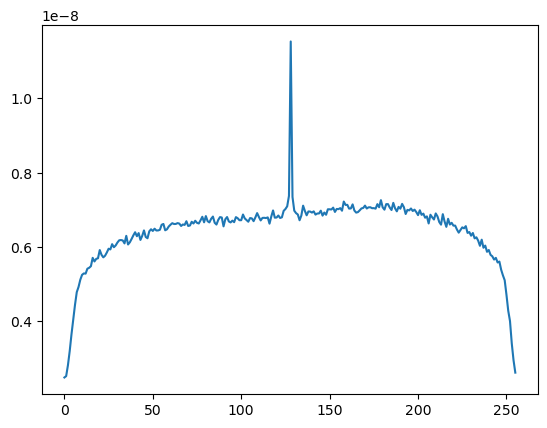

In [20]:
plt.plot(np.abs(dset[10000,3,:]))

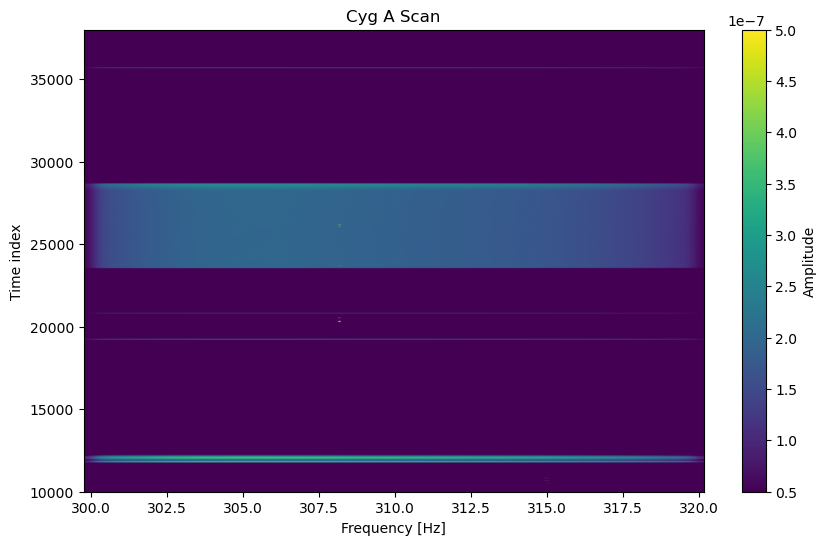

In [51]:
from matplotlib.pyplot import clim, xlim


data_slice = np.abs(dset[10000:38000, 1, :])  # shape (18000, 256)

plt.figure(figsize=(10, 6))
plt.imshow(
    data_slice,
    aspect='auto',
    clim=(0.5*1e-7, 0.5*1e-6),
    extent=(freq.min(), freq.max(), 10000, 38000),  # x = freq, y = time indices
    origin='lower'  # so lower index is at bottom
)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Time index")
plt.title("Cyg A Scan")
plt.colorbar(label="Amplitude")
plt.show()


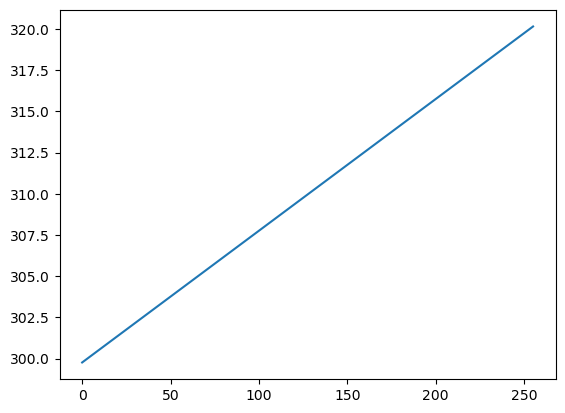

In [38]:
plt.plot(freq)

In [9]:
# Inspect the data structure
print("Data shapes:")
for key, value in data.items():
    print(f"  {key}: {value.shape}")

# Look for time and frequency arrays
# Common names might be: time, times, t, frequency, frequencies, freq, f
time_keys = [k for k in data.keys() if any(term in k.lower() for term in ['time', 't'])]
freq_keys = [k for k in data.keys() if any(term in k.lower() for term in ['freq', 'frequency', 'f'])]

print(f"\nPotential time keys: {time_keys}")
print(f"Potential frequency keys: {freq_keys}")

Data shapes:
  data/freq: (256,)
  data/id: (50110,)

Potential time keys: ['data/freq', 'data/id']
Potential frequency keys: ['data/freq']


In [10]:
# Extract time and frequency arrays
# Adjust these key names based on the actual structure of your HDF5 file
# Common patterns: 'time', 'times', 't' for time; 'frequency', 'frequencies', 'freq', 'f' for frequency

# Try to find time and frequency automatically
time = None
frequency = None

for key in data.keys():
    if 'time' in key.lower() and time is None:
        time = data[key]
        print(f"Using '{key}' for time: shape {time.shape}")
    if 'freq' in key.lower() and frequency is None:
        frequency = data[key]
        print(f"Using '{key}' for frequency: shape {frequency.shape}")

# If not found, you may need to manually specify:
# time = data['time']  # or whatever the actual key is
# frequency = data['frequency']  # or whatever the actual key is

if time is None or frequency is None:
    print("\nWarning: Could not automatically find time/frequency arrays.")
    print("Please manually specify the keys in the cell above.")

Using 'data/freq' for frequency: shape (256,)

Please manually specify the keys in the cell above.


In [11]:
# Extract the four measurements (polarizations)
# Common names: XX, YY, XY, YX or similar
# Filter for 2D arrays that match the expected shape (n_time, n_freq)

polarization_data = {}
for key, value in data.items():
    # Look for 2D arrays that could be polarization measurements
    if value.ndim == 2:
        # Check if shape matches time x frequency
        if time is not None and frequency is not None:
            if value.shape == (len(time), len(frequency)):
                polarization_data[key] = value
                print(f"Found polarization measurement '{key}': shape {value.shape}")

# If we found exactly 4 measurements, use them
if len(polarization_data) == 4:
    
    print(f"\nFound 4 measurements: {list(polarization_data.keys())}")
else:
    print(f"\nFound {len(polarization_data)} measurements. Please verify these are the correct ones.")
    print("If needed, manually select the four measurements you want to plot.")


Found 0 measurements. Please verify these are the correct ones.
If needed, manually select the four measurements you want to plot.


In [12]:
# Plot the four measurements using the plot_polarizations function
if time is not None and frequency is not None and len(polarization_data) > 0:
    utils.plot_polarizations(
        time=time,
        frequency=frequency,
        polarizations=polarization_data,
        figsize=(15, 10),
        cmap="viridis"
    )
else:
    print("Cannot plot: missing time, frequency, or polarization data.")
    print("Please check the previous cells and adjust the key names as needed.")

Cannot plot: missing time, frequency, or polarization data.
Please check the previous cells and adjust the key names as needed.
